In [4]:
import pandas as pd

## Load and Normalize Data

In [5]:
file_path = 'eth_usdc.json'
data = pd.read_json(file_path)

# Normalize the nested JSON data into a DataFrame
df = pd.json_normalize(data['data'])

# Convert necessary columns to appropriate data types
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['delta0'] = df['delta0'].astype(float)
df['delta1'] = df['delta1'].astype(float)


In [19]:
df.head()

,type,pool_key_hash,fee,tick_spacing,extension,timestamp,transaction_hash,event_id,locker,delta0,delta1
0,0,3433647365636055192408323943727979665795347486...,170141183460469235273462165868118016,1000,0,2024-12-30 14:28:44+00:00,2875971176631024664104163427790566357222222366...,4409136117317633,1951224604049798639815629089492514906598247071...,-2.092927e+17,7.000000e+08
1,0,3433647365636055192408323943727979665795347486...,170141183460469235273462165868118016,1000,0,2024-12-30 14:28:13+00:00,3277940467676076779594366303731264633655397835...,4409131822022657,1951224604049798639815629089492514906598247071...,-1.794333e+17,6.000000e+08
2,0,3433647365636055192408323943727979665795347486...,170141183460469235273462165868118016,1000,0,2024-12-30 14:28:13+00:00,2567692597872700272292372505099219868639337413...,4409131821694977,1951224604049798639815629089492514906598247071...,-2.692184e+17,9.000000e+08
3,0,3433647365636055192408323943727979665795347486...,170141183460469235273462165868118016,1000,0,2024-12-30 14:27:42+00:00,3380307119346874738946403883043418502991214459...,4409127528103937,1951224604049798639815629089492514906598247071...,-1.645634e+17,5.500000e+08
4,0,3433647365636055192408323943727979665795347486...,170141183460469235273462165868118016,1000,0,2024-12-30 14:27:42+00:00,2652058672694745023076733619924622841544142956...,4409127527776257,1951224604049798639815629089492514906598247071...,-2.992868e+17,1.000000e+09


## Filter the Most Liquid Fee Tier Pool

In [7]:
# Identify the most liquid pool
most_liquid_pool = df['pool_key_hash'].value_counts().idxmax()
most_liquid_pool_data = df[df['pool_key_hash'] == most_liquid_pool]

# Check unique fee tiers
fee_tiers = most_liquid_pool_data['fee'].value_counts()
print(f"The most liquid pool is: {most_liquid_pool}")
print(f"Fee tiers: {fee_tiers}")



The most liquid pool is: 343364736563605519240832394372797966579534748662016872201364916213608434840
Fee tiers: fee
170141183460469235273462165868118016    67
Name: count, dtype: int64


## Calculate Capital Over Time and Normalize to $1000

In [8]:
# Group by user (locker) and calculate cumulative capital over time
capital_over_time = most_liquid_pool_data.groupby(['locker', 'timestamp'])[['delta0', 'delta1']].sum().groupby(level=0).cumsum()

# Normalize investments to $1000 (assuming a 1:1 price ratio for simplicity)
capital_over_time_normalized = capital_over_time.div(capital_over_time.abs().sum(axis=1), axis=0) * 1000

# Add a HODL baseline
capital_over_time_normalized['HODL'] = 1000

## Plot Capital Dollar Value vs Time

Matplotlib is building the font cache; this may take a moment.


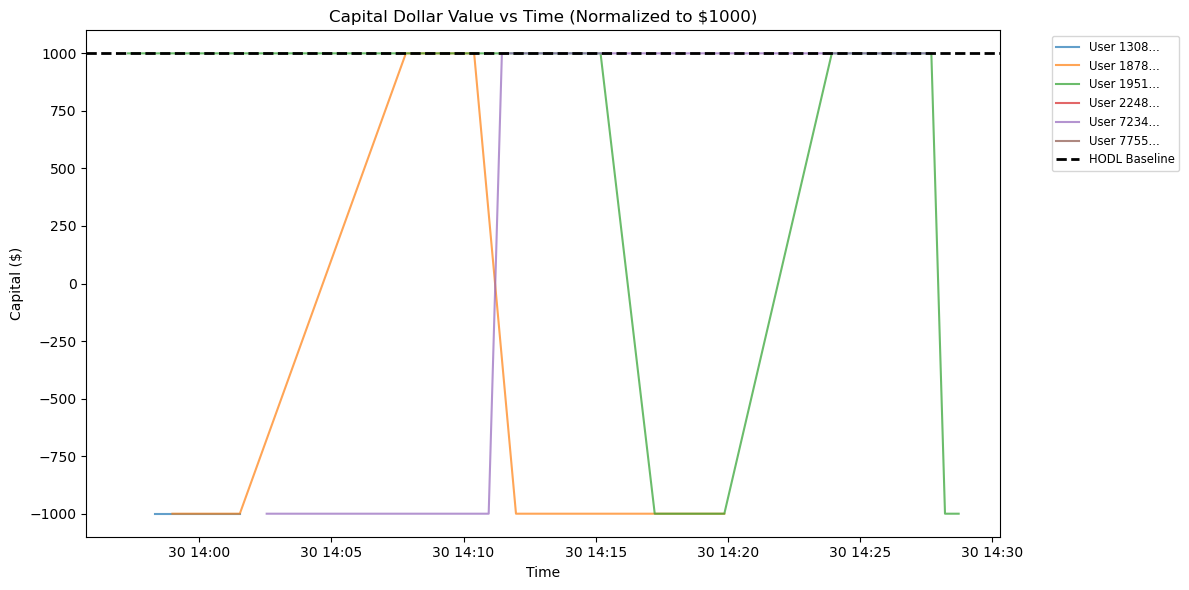

In [9]:
import matplotlib.pyplot as plt

# Plot capital dollar value over time for all users
plt.figure(figsize=(12, 6))
for locker, user_data in capital_over_time_normalized.groupby(level=0):
    plt.plot(user_data.index.get_level_values(1), user_data['delta0'], label=f'User {locker[:4]}...', alpha=0.7)

# Plot HODL baseline
plt.axhline(y=1000, color='black', linestyle='--', linewidth=2, label='HODL Baseline')

plt.title("Capital Dollar Value vs Time (Normalized to $1000)")
plt.xlabel("Time")
plt.ylabel("Capital ($)")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')
plt.tight_layout()
plt.show()


## Identify Top 10 Most Profitable Users

In [20]:
# Calculate investment duration for each user
investment_duration = most_liquid_pool_data.groupby('locker')['timestamp'].apply(lambda x: (x.max() - x.min()).days)
print(investment_duration.describe())  # Summary of investment durations
print(investment_duration[investment_duration >= 15])  # Users who do not meet the criteria


count    6.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: timestamp, dtype: float64
Series([], Name: timestamp, dtype: int64)


In [21]:
# Calculate profitability compared to HODL
capital_over_time_normalized['Profit'] = capital_over_time_normalized['delta0'] - capital_over_time_normalized['HODL']

# Filter users with at least 60 days of investment
investment_duration = most_liquid_pool_data.groupby('locker')['timestamp'].apply(lambda x: (x.max() - x.min()).days)
eligible_users = investment_duration[investment_duration >= 15].index

# Find top 10 profitable users
top_users = capital_over_time_normalized.loc[eligible_users].groupby(level=0)['Profit'].max().nlargest(10)
print(f"Top 10 users: {top_users}")


Top 10 users: Series([], Name: Profit, dtype: float64)


## Plot Number of Rebalances for Top 10 Users

IndexError: index 0 is out of bounds for axis 0 with size 0

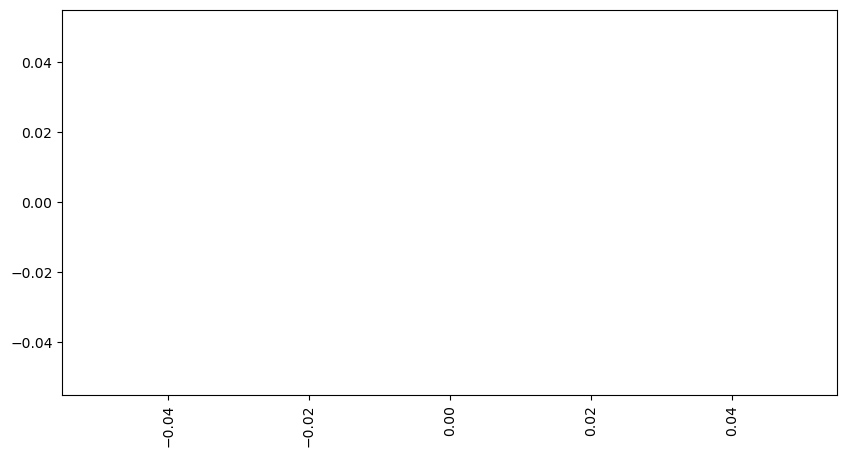

In [11]:
# Count rebalances for each top user
rebalances = most_liquid_pool_data[most_liquid_pool_data['locker'].isin(top_users.index)].groupby('locker')['transaction_hash'].nunique()

# Plot
plt.figure(figsize=(10, 5))
rebalances[top_users.index].plot(kind='bar', color='skyblue')
plt.title("Number of Rebalances for Top 10 Users")
plt.xlabel("User")
plt.ylabel("Rebalances")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Plot Annualized Profit Percentage for Top 10 Users

IndexError: index 0 is out of bounds for axis 0 with size 0

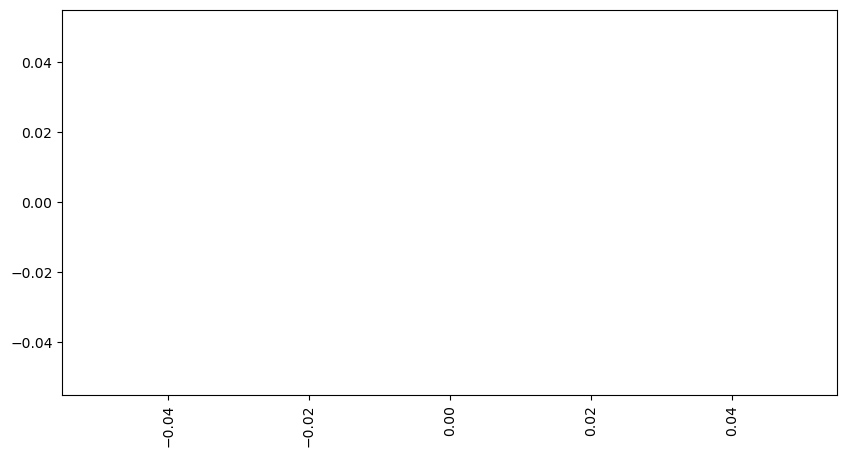

In [12]:
# Calculate annualized profit percentage for top users
annualized_profit = (top_users / 1000) * (365 / 60)  # Assuming 60-day minimum period

# Plot
plt.figure(figsize=(10, 5))
annualized_profit.plot(kind='bar', color='coral')
plt.title("Annualized Profit Percentage for Top 10 Users")
plt.xlabel("User")
plt.ylabel("Profit % (Annualized)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
